## MCP Agent

This example demonstrates how to create a stringdale diagram that implements a complete MCP tool selection cycle:
1. User query input
2. LLM selects tool from available MCP tools
3. Execute selected tool via MCP client
4. Analyze tool output
5. Loop back or return final answer


In [1]:
#| default_exp examples.mcp_agent

In [2]:
#| hide
%load_ext autoreload
%autoreload 2


In [3]:
#| hide
from stringdale.core import get_git_root, load_env, checkLogs
load_env()


True

In [98]:
#| export
from typing import Optional, List, Dict, Any
from pydantic import BaseModel, Field
from stringdale import Define, V, E, Condition, Scope
from stringdale.chat import Chat
import os

from fastmcp import Client
import asyncio


In [5]:
BRAVE_API_KEY = os.getenv("BRAVE_API_KEY")
#wiki_loc = str(get_git_root()/'sample_data/wiki')
wiki_loc = str(get_git_root()/'nbs/docs/examples/wiki')

In [6]:
wiki_loc

'/Users/olgasoldatenko/work/newer/stringdale/nbs/docs/examples/wiki'

In [7]:
config = {
  "mcpServers": {
    "filesystem": {
      "command": "npx",
      "args": [
        "-y",
        "@modelcontextprotocol/server-filesystem",
        wiki_loc,
      ]
    },
    "brave-search": {
            "command": "npx",
            "args": ["-y", "@modelcontextprotocol/server-brave-search"],
            "env": {
                "BRAVE_API_KEY": BRAVE_API_KEY
            }
        }
  }
}



In [8]:
mcp_client = Client(config)


In [9]:
async with mcp_client:
    mcp_tools = await mcp_client.list_tools()

In [10]:
mcp_tools

[Tool(name='filesystem_read_file', title='Read File (Deprecated)', description='Read the complete contents of a file as text. DEPRECATED: Use read_text_file instead.', inputSchema={'$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'object', 'properties': {'path': {'type': 'string'}, 'tail': {'description': 'If provided, returns only the last N lines of the file', 'type': 'number'}, 'head': {'description': 'If provided, returns only the first N lines of the file', 'type': 'number'}}, 'required': ['path']}, outputSchema={'$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'object', 'properties': {'content': {'type': 'string'}}, 'required': ['content'], 'additionalProperties': False}, icons=None, annotations=ToolAnnotations(title=None, readOnlyHint=True, destructiveHint=None, idempotentHint=None, openWorldHint=None), meta={'_fastmcp': {'tags': []}}),
 Tool(name='filesystem_read_text_file', title='Read Text File', description="Read the complete contents of a file from

In [11]:
#| export
# Chat node for tool selection with MCP tools
# This chat will be used in the diagram to select tools
mcp_tool_selector = Chat(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "{{user_query}}"}
    ],
    mcp_tools=mcp_tools,
)

res = Chat(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "{{user_query}}"},
        {"role": "function", "name": "{{tool_name}}", "content": "{{tool_response_text}}"},
    ]        
)

# Chat node for generating user-friendly final answer
final_answer_chat = Chat(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user", 
            "content": "Original question: {{user_query}}\n\nTool result: {{tool_result}}\n\nPlease provide a clear, user-friendly answer based on the tool result that directly addresses the original question."
        }
    ]
)

In [12]:
await mcp_tool_selector(user_query="What information do we have about dogs in our wiki, and what are the latest news or recent developments about dogs?")

{'role': 'assistant',
 'content': {'text': None,
  'tool_calls': [{'name': 'brave-search_brave_web_search',
    'input': {'query': 'dogs', 'count': 5},
    'id': 'call_xs2m6XLApHA1SCTEsGsbMnNv'},
   {'name': 'filesystem_search_files',
    'input': {'path': 'wiki', 'pattern': 'dogs.md'},
    'id': 'call_QSVL8FLmlVjGnrosEREgSFOY'}]},
 'meta': {'input_tokens': 1469, 'output_tokens': 60}}

In [13]:
await mcp_tool_selector(user_query="Search internet for newest dog breeds")

{'role': 'assistant',
 'content': {'text': None,
  'tool_calls': [{'name': 'brave-search_brave_web_search',
    'input': {'query': 'newest dog breeds', 'count': 10},
    'id': 'call_LzJfIWUWQ0ZBC4m6psLdRdJM'}]},
 'meta': {'input_tokens': 1452, 'output_tokens': 26}}

In [87]:
#| export
async def execute_tool(tool):
    """
    Extracts the tool name and arguments from the first tool_call in the LLM response,
    executes the tool via mcp_client, and returns the tool response text.
    """
    tool_name = tool['name']
    tool_args = tool['input']  # Already a dict
    async with mcp_client:
        tool_response = await mcp_client.call_tool(tool_name, tool_args)
        tool_response_text = tool_response.content[0].text
    return tool_response_text


In [76]:
#| export
# Condition to check if tools were selected
#we would do for each in a diagram
# Condition if use tools otherwise end
def has_tool_calls(llm_response):
    # for now don't check anything
    if llm_response is not None:
        return True
    return True



In [77]:
# message formatting would look sonething like this

def format_message(llm_response,tool_call_result,tool_call_id):
    assistant_content = []

    assistant_content = llm_response['content']
    messages = [
    {
        "role": "assistant",
        "content": assistant_content
    },
    {
        "role": "user",
        "content": [
            {
                "type": "tool_result",
                "tool_use_id": tool_call_id,
                "content": tool_call_result.content
            }
        ]
    }
    ]

In [91]:
#| export
# Create the MCP Agent diagram
with Define('MCP Agent', type='decision') as MCPAgent:
    # Start: User query comes in
    # Select tool: Chat with MCP tools to decide which tool to use
    V('select_tool', mcp_tool_selector,
      inputs=['Start(user_query=.)'],
      outputs=[
          ('End'),
          ('Start_flow(tools=content.tool_calls)', Condition(has_tool_calls,'(0=content.tool_calls)'))
      ])
    E('Start->State/user_query')
    # Execute the selected tool
    V('Start_flow',
    outputs=[('execute_tool(tool = tools)')]
    )
    with Scope('flow'):
      V('execute_tool', execute_tool,
      for_each=['tool']
      #outputs=['format_result(tool_result=.)']
      )
    #E('execute_tool->End')
    # # Format tool result for summary
    # V('format_result', format_message,
    #   inputs=['execute_tool(tool_call=.)'],
    #   outputs=['another_chat()'])
     # Format the final answer for the user
    V('format_answer', final_answer_chat,
      inputs=[
          'execute_tool(tool_result=.)',
          'State/user_query(user_query=.)'  # Pass original query from Start
      ],
      outputs=['End'])

    

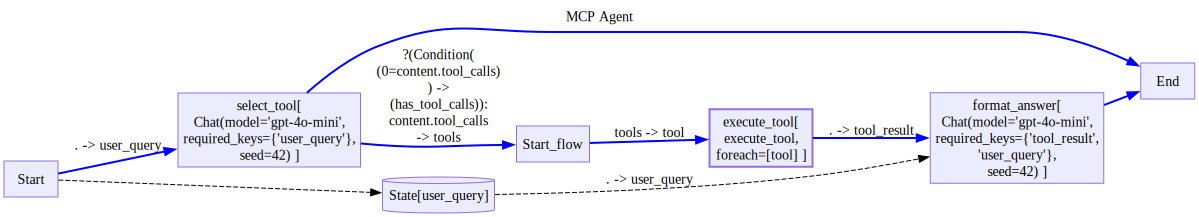

In [92]:
MCPAgent.draw()

In [93]:
d1 = MCPAgent()
user_input = user_query="What information do I have about dogs in our wiki?"
for trace in d1.run(user_input):
    trace.pprint()

/Users/olgasoldatenko/work/newer/stringdale/stringdale/base.py:86: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  type_fields = obj.model_fields


ValueError: When running node 'execute_tool[None]':
Function <function execute_tool at 0x11d2bf2e0>
args=[]
kwargs={'tool': [{'name': 'filesystem_search_files', 'input': {'path': 'wiki', 'pattern': '*dogs*'}, 'id': 'call_AHIgZdrg0lavWIokXbmFq56s'}]}
returned Error 
'list indices must be integers or slices, not str'


In [86]:
d = MCPAgent()
user_input = user_query="What information do I have about dogs in our wiki, and what are the latest news or recent developments about dogs?"
for trace in d.run(user_input):
    trace.pprint()
    #trace.pprint(drop_keys=['input'])

/Users/olgasoldatenko/work/newer/stringdale/stringdale/base.py:86: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  type_fields = obj.model_fields


In [95]:
async def async_add(a,b,c):
    await asyncio.sleep(0.1)
    return a+b+c

async def async_add100(a):
    await asyncio.sleep(0.1)
    return a+100


class Range:
    def __init__(self,length,step=1):
        self.length = length
        self.step = step
    def __call__(self,initial_value=0):
        return list(range(initial_value,initial_value+self.length*self.step,self.step))
    def __str__(self):
        return f'Range({self.length},{self.step})'

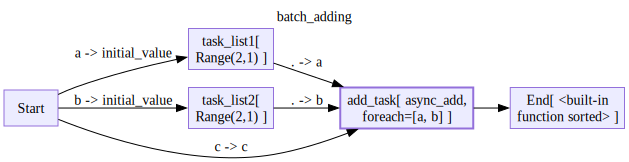

In [96]:
with Define('batch_adding') as D:
    V('task_list1',Range(2),inputs=['Start(initial_value=a)'])
    V('task_list2',Range(2),inputs=['Start(initial_value=b)'])
    V('add_task',async_add,
        inputs=['task_list1(a=.)','task_list2(b=.)','Start(c=c)'],
        # for each is a list of input ports to map the function on
        # in this case, we have input ports a,b and c
        # a and b are for each, so we will run async_add for each combination of item from a and item from b
        # c is not in for_each, so it will be the same for each run
        for_each=['a','b'])
    
    # since async_add is now a foreach node, it will be called multiple times and the results will be collected into a list
    # before being fed into a regular node
    # we can sort the list to make sure that the results are deterministic
    V('End',sorted,inputs=['add_task'])
D.draw()

In [99]:
d=D()
for trace in d.run({'a':1000,'b':100,'c':10}):
    trace.pprint()